In [4]:
import pandas as pd
import sqlite3
import hashlib
import numpy as np
import datetime

In [5]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [6]:
db_path = "../../Databases/database.sqlite"

db = sqlite3.connect(db_path)

In [7]:
def hash_row(column_values):
    """function to create a hashkey of a row of a table"""
    string_vars = [str(c).strip().upper() if c is not None else "" for c in column_values]
    string_vars = [c.replace(" ", "_") for c in string_vars]
    # join them
    one_string = "_".join(string_vars)
    
    # hash gen
    hash_gene = hashlib.new("whirlpool")
    
    hash_gene.update(one_string.encode("utf-8")) 
    
    return hash_gene.hexdigest()

In [8]:
def get_primary_key(table: str, db) -> str:
    """returns the name of the primary key of a table from a SQL database if index was created properly"""
    try:
        info = pd.read_sql(f"PRAGMA table_info({table})", con = db);
        ind = info.index[info.pk == 1].item()
        cols = get_column_names(table, db)
        pk = cols[ind]
        return pk
    except:
        return f"Table 'index_info' not found, can't get primary key of {table}"

In [9]:
def get_column_names(table: str, db) -> list:
    """returns a list of the column names of a table from a SQL database
    if index was created properly"""
    df_column = pd.read_sql(f'PRAGMA table_info({table});', con=db)
    return df_column['name'].to_list()

In [10]:
def get_table_names(db) -> list:
    """returns a list of all the names of the tables of a SQL database"""
    query = (
    'SELECT name FROM sqlite_master '
    'WHERE type IN ("table", "view") '
    'AND name NOT LIKE "sqlite_%"'
    ';'
    )
    table = pd.read_sql(query, con=db)
    return table['name'].to_list()

In [11]:
# list of table names
tables = get_table_names(db)

# list of primary keys
pri_keys_dict = {t: get_primary_key(table, db) for t, table in zip(tables, tables)}
df_dict = {}

# loop over tables
for table in tables:
    df = pd.read_sql(f"SELECT * FROM {table}", con = db)
    df_dict[table] = df
    
                     
                     

In [12]:
pri_keys_dict

{'Player_Attributes': 'id',
 'Player': 'id',
 'Match': 'id',
 'League': 'id',
 'Country': 'id',
 'Team': 'id',
 'Team_Attributes': 'id',
 'TEST': 'BK',
 'HUB_Player': 'HK',
 'HUB_League': 'HK',
 'HUB_Team': 'HK'}

In [13]:
for key, values in df_dict.items():
    print(f"Length of {key} : ",len(df_dict[key]))

Length of Player_Attributes :  183978
Length of Player :  11060
Length of Match :  25979
Length of League :  11
Length of Country :  11
Length of Team :  299
Length of Team_Attributes :  1458
Length of TEST :  0
Length of HUB_Player :  0
Length of HUB_League :  0
Length of HUB_Team :  0


In [14]:
for key in df_dict.keys():
    print(key, "\n", df_dict[key].columns)

Player_Attributes 
 Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')
Player 
 Index(['id', 'player_api_id', 'player_name', 'player_fifa_api_id', 'birthday',
       'height', 'weight'],
      dtype='object')
Match 
 Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_ap

In [15]:
for key in df_dict.keys():
    df = df_dict[key]
    print("table:", key, "\n\n", df.isnull().sum())

table: Player_Attributes 

 id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking             

## Understanding the Data

In [16]:
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import random

In [17]:
match_df = df_dict["Match"]
match_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [18]:
match_df.isnull().sum()

id                      0
country_id              0
league_id               0
season                  0
stage                   0
date                    0
match_api_id            0
home_team_api_id        0
away_team_api_id        0
home_team_goal          0
away_team_goal          0
home_player_X1       1821
home_player_X2       1821
home_player_X3       1832
home_player_X4       1832
home_player_X5       1832
home_player_X6       1832
home_player_X7       1832
home_player_X8       1832
home_player_X9       1832
home_player_X10      1832
home_player_X11      1832
away_player_X1       1832
away_player_X2       1832
away_player_X3       1832
away_player_X4       1832
away_player_X5       1832
away_player_X6       1832
away_player_X7       1832
away_player_X8       1832
away_player_X9       1833
away_player_X10      1833
away_player_X11      1839
home_player_Y1       1821
home_player_Y2       1821
home_player_Y3       1832
home_player_Y4       1832
home_player_Y5       1832
home_player_

#### Matches Per Season

In [19]:
league_df = df_dict["League"]
league_df.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [20]:
# names of the leagues we can get from the league df
league_names_dict = {k: v for k, v in zip(league_df["id"], league_df["name"])}

In [21]:
league_names_dict

{1: 'Belgium Jupiler League',
 1729: 'England Premier League',
 4769: 'France Ligue 1',
 7809: 'Germany 1. Bundesliga',
 10257: 'Italy Serie A',
 13274: 'Netherlands Eredivisie',
 15722: 'Poland Ekstraklasa',
 17642: 'Portugal Liga ZON Sagres',
 19694: 'Scotland Premier League',
 21518: 'Spain LIGA BBVA',
 24558: 'Switzerland Super League'}

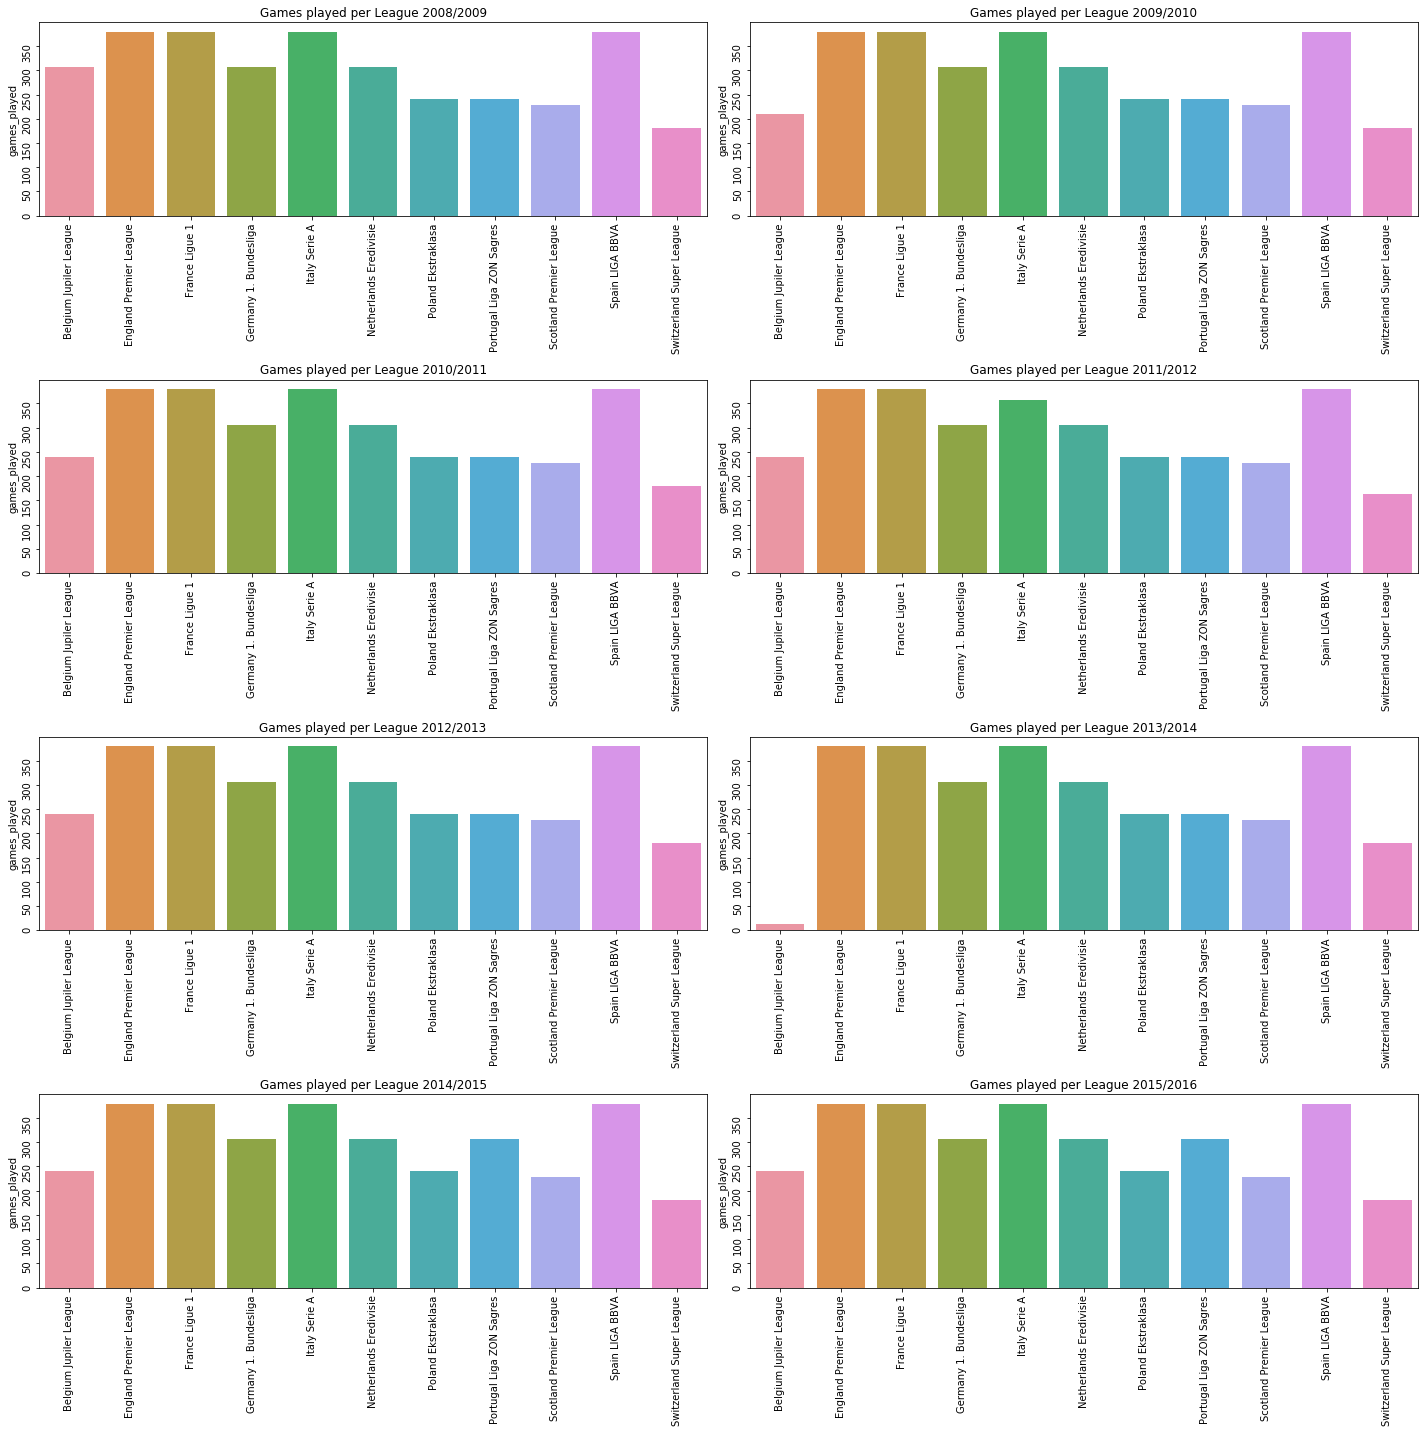

In [22]:
# season list
seasons = match_df.season.unique()

# lists for grid
rows = [0, 0, 1, 1, 2, 2, 3, 3]
cols = [0, 1, 0, 1, 0, 1, 0, 1]

# subplots
fig, ax = plt.subplots(4, 2, figsize = (20, 20))

for season, row, col in zip(seasons, rows, cols):
    season_df = match_df[match_df.season == season]
    
    league_season_df = season_df.groupby("league_id")["id"].count()
    
    names = [league_names_dict[key] for key in league_season_df.index]

    df = pd.DataFrame({
        "name" : names,
        "games_played" : league_season_df.values
    })
    plt.tight_layout()
    sns.barplot(df.name, df.games_played, ax = ax[row, col])
    ax[row, col].tick_params(labelrotation=90)
    ax[row, col].set_xlabel("")
    ax[row, col].set_title("Games played per League " + season)
        

## Did the home team win more games than the away team?

Text(0, 0.5, 'Away Goals')

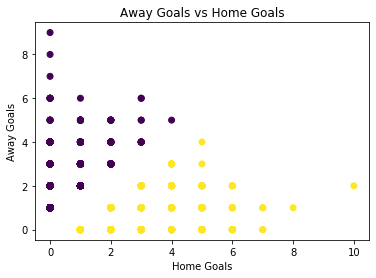

In [23]:
match_subset = match_df[(match_df.season == "2015/2016") & (match_df.away_team_goal != match_df.home_team_goal)][["away_team_goal", "home_team_goal"]]
match_subset["home_won"] = np.where(match_subset.home_team_goal > match_subset.away_team_goal, 1, 0)

plt.scatter(match_subset.home_team_goal, match_subset.away_team_goal, c = match_subset.home_won)
plt.title("Away Goals vs Home Goals")
plt.xlabel("Home Goals")
plt.ylabel("Away Goals")

In [24]:
player_df = df_dict["Player"]
player_df.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


Text(0, 0.5, 'Weight')

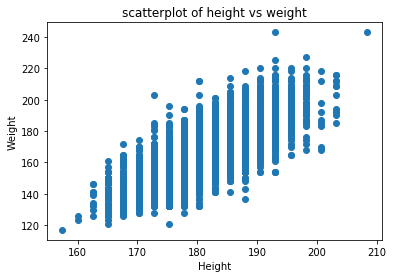

In [25]:
# correlation between height and weight?
plt.scatter(player_df.height, player_df.weight)
plt.title("scatterplot of height vs weight")
plt.xlabel("Height")
plt.ylabel("Weight")

In [26]:
player_attr = df_dict["Player_Attributes"]
player_attr.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


C:\Users\Leonhard\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


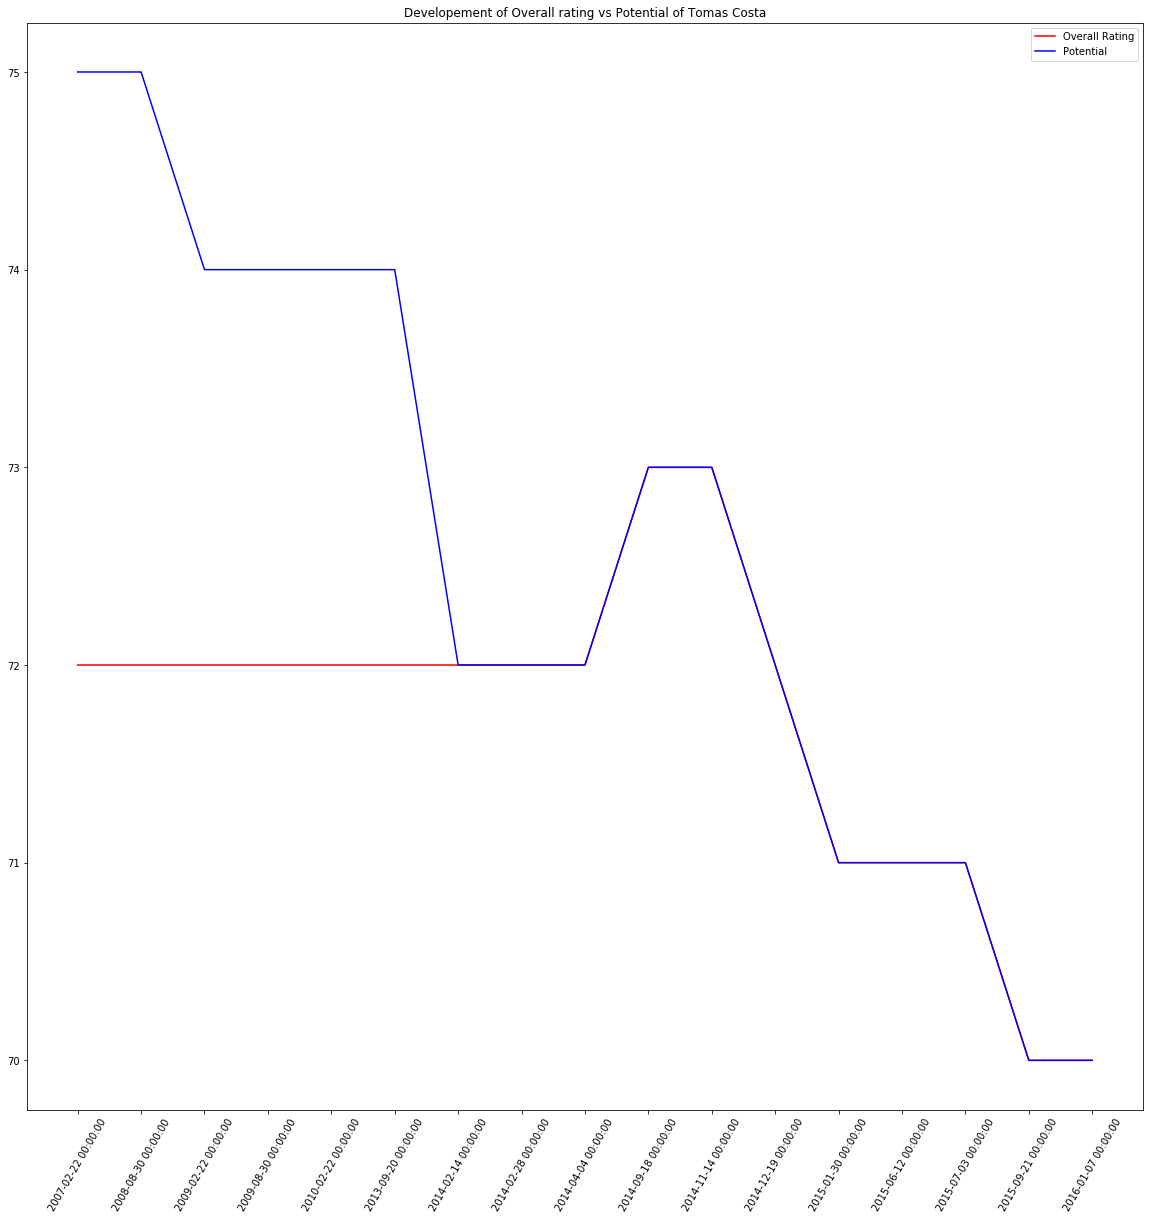

In [27]:
rand_player = player_attr[player_attr.player_api_id == random.choice(player_df.player_api_id)]
rand_player.sort_values(by = "date", inplace = True)

fig, ax = plt.subplots( figsize = (20,20))
ax.plot(rand_player.date, rand_player.overall_rating, color = "red")
ax.plot(rand_player.date, rand_player.potential, "blue")
ax.legend(["Overall Rating", "Potential"])
plt.xticks(rotation=60)

ax.set_title("Developement of Overall rating vs Potential of " + player_df[player_df.player_api_id == rand_player.player_api_id.iloc[0]]["player_name"].item());

In [28]:
country_df = df_dict["Country"]
country_df.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [29]:
team_df = df_dict["Team"]
team_df.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [30]:
team_df.nunique()

id                  299
team_api_id         299
team_fifa_api_id    285
team_long_name      296
team_short_name     259
dtype: int64

In [31]:
team_attr = df_dict["Team_Attributes"]
team_attr.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [32]:
player_attr.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes'],
      dtype='object')

In [33]:
match_df.columns[10:]

Index(['away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3',
       'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7',
       'home_player_X8', 'home_player_X9',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=105)

In [34]:
match_df = pd.read_sql("SELECT * from Match", con = db)

In [35]:
match_df.goal.isnull().sum()

11762

In [36]:
match_df.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)